# PPOのCriticネットワークを事前学習する

In [5]:
import os
import sys
from pathlib import Path
from typing import List, Optional, Tuple
import random
from dataclasses import dataclass
import copy

import torch
if torch.cuda.is_available():
    from torch.cuda.amp import autocast, GradScaler
else:
    from torch.amp import autocast, GradScaler
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, ListedColormap
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR
import torchinfo
import optuna
from PIL import Image

from contextlib import nullcontext

project_root = Path.cwd().parent
sys.path.append(str(project_root))

# omnicampus環境との違い
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == "cuda":
    BOARD_TRAIN_DIR = os.path.join("data", "egaroucid")
else:
    BOARD_TRAIN_DIR = os.path.join(project_root, "data", "egaroucid")


Using device: mps


## データセットの作成

In [6]:
def plot_board(board: np.ndarray, score: int):
    """
    1は青、-1は赤, 0は黒
    """
    cmap = ListedColormap(["#d62728", "#2f2f2f", "#1f77b4"])  # -1, 0, 1
    norm = BoundaryNorm([-1.5, -0.5, 0.5, 1.5], cmap.N)

    im = plt.imshow(board, cmap=cmap, norm=norm)
    cbar = plt.colorbar(im, ticks=[-1, 0, 1])
    cbar.ax.set_yticklabels(["-1", "0", "1"])

    plt.title(f"Board, score: {score}")
    plt.show()

In [7]:
board_npy = np.load(os.path.join(BOARD_TRAIN_DIR, "boards.npy"))
score_npy = np.load(os.path.join(BOARD_TRAIN_DIR, "scores.npy"))
print(board_npy.shape, score_npy.shape)

(100000, 8, 8) (100000,)


In [ ]:
# 1万個のみにランダムに選択
seed = 42
np.random.seed(seed)
rand_idx = np.random.choice(len(board_npy), size=10000, replace=False)
board_npy = board_npy[rand_idx]
score_npy = score_npy[rand_idx]
print(board_npy.shape, score_npy.shape)

(30000, 8, 8) (30000,)


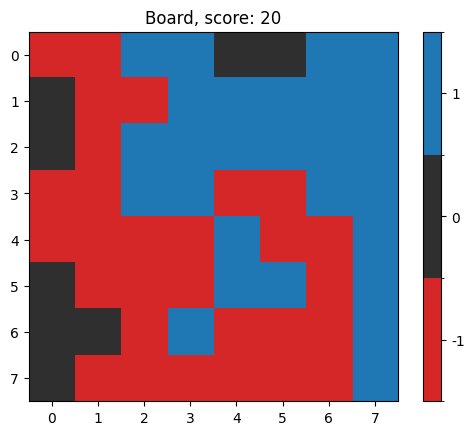

In [9]:
rand_idx = random.randint(0, len(board_npy) - 1)
plot_board(board_npy[rand_idx], score_npy[rand_idx])

In [10]:
class OthelloDataset(Dataset):
    def __init__(self, boards: np.ndarray, scores: np.ndarray, transform: Optional[T.Compose] = None) -> None:
        super().__init__()
        self.boards = boards
        self.scores = scores
        self.transform = transform

    def __len__(self) -> int:
        return len(self.boards)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        board = torch.from_numpy(self.boards[idx]).unsqueeze(0)
        if self.transform:
            board = self.transform(board)
        score = torch.tensor(self.scores[idx], dtype=torch.float32)
        return board, score

In [11]:
# scoreは、-64~64の範囲なので、-1~1の範囲に正規化する
score_npy = score_npy / 64.0

# board_npyとscore_npyをtrain, valid, testに分割して、それぞれのデータセットを作成する
# 70%をtrain, 15%をvalid, 15%をtestとする
train_boards = board_npy[: int(len(board_npy) * 0.7)]
train_scores = score_npy[: int(len(score_npy) * 0.7)]
val_boards = board_npy[int(len(board_npy) * 0.7) : int(len(board_npy) * 0.85)]
val_scores = score_npy[int(len(score_npy) * 0.7) : int(len(score_npy) * 0.85)]
test_boards = board_npy[int(len(board_npy) * 0.85) :]
test_scores = score_npy[int(len(score_npy) * 0.85) :]

# データ拡張として、上下左右反転を追加する
transform = T.Compose([
    T.RandomVerticalFlip(p=0.5),
    T.RandomHorizontalFlip(p=0.5),
])

# データセットを作成する
train_dataset = OthelloDataset(train_boards, train_scores, transform)
val_dataset = OthelloDataset(val_boards, val_scores)
test_dataset = OthelloDataset(test_boards, test_scores)

In [12]:
print(train_dataset[0])

(tensor([[[ 0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0, -1,  0, -1,  0,  0],
         [ 0,  1,  1,  1, -1, -1,  0,  0],
         [ 1,  1,  1,  1, -1, -1,  0,  0],
         [ 1,  1,  1,  1, -1, -1,  0,  0],
         [ 0,  0,  1,  1,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  0]]]), tensor(-0.1250))


-0.125


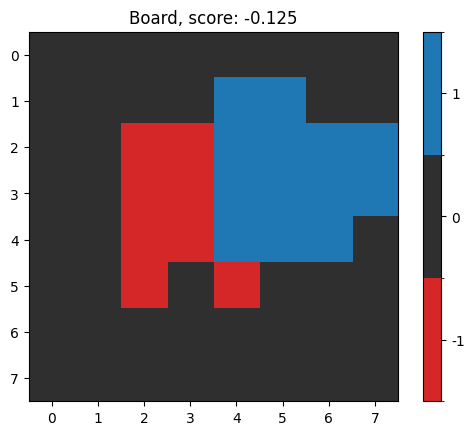

In [13]:
print(train_scores[0])

board_np = train_dataset[0][0].squeeze().numpy()
score_np = train_dataset[0][1].numpy()
plot_board(board_np, score_np)

## Criticアーキテクチャの定義

In [14]:
class ResBlock(nn.Module):
    def __init__(self, ch: int, bn_eps: float = 1e-5, zero_init: bool = True):
        super().__init__()
        self.conv1 = nn.Conv2d(ch, ch, 3, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(ch, eps=bn_eps)
        self.conv2 = nn.Conv2d(ch, ch, 3, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(ch, eps=bn_eps)
        if zero_init:
            # 出力を初期は恒等写像に近づけて安定化
            nn.init.zeros_(self.bn2.weight)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        h = F.relu(self.bn1(self.conv1(x)))
        h = self.bn2(self.conv2(h))
        return F.relu(x + h)

class CriticNet(nn.Module):
    def __init__(
        self,
        in_ch: int = 2,
        width: int = 32,
        num_res_blocks: int = 3,
        bn_eps: float = 1e-5,
        head_hidden_size: int = 32,
        use_gap: bool = True,
        norm_head: str = "ln",
    ):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(in_ch, width, 3, padding=1, bias=False),
            nn.GroupNorm(1, width, eps=bn_eps),
            nn.ReLU(inplace=True),
        )
        self.res_blocks = nn.Sequential(
            *[ResBlock(width, bn_eps=bn_eps, zero_init=True) for _ in range(num_res_blocks)]
        )

        # value head: 1x1 conv → (norm) → ReLU
        self.value_conv = nn.Conv2d(width, 1, kernel_size=1, bias=False)

        if norm_head == "bn":
            self.value_norm = nn.GroupNorm(1, 1, eps=bn_eps)
        elif norm_head == "ln":
            # LayerNorm over (C,H,W) = (1,8,8) -> normalized_shape=(1,8,8)
            self.value_norm = nn.LayerNorm((1, 8, 8))
        elif norm_head == "gn":
            self.value_norm = nn.GroupNorm(1, 1)  # 1 group = LayerNorm的
        else:
            self.value_norm = nn.Identity()

        self.use_gap = use_gap
        if use_gap:
            in_fc = 1  # GAPで(1,)に
        else:
            in_fc = 8 * 8

        self.value_fc1 = nn.Linear(in_fc, head_hidden_size)
        self.value_fc2 = nn.Linear(head_hidden_size, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        h = self.stem(x)
        h = self.res_blocks(h)

        h = self.value_conv(h)  # (B,1,8,8)
        if isinstance(self.value_norm, nn.LayerNorm):
            h = self.value_norm(h)  # 形状そのまま
        else:
            h = self.value_norm(h)
        h = F.relu(h)

        if self.use_gap:
            h = h.mean(dim=(2, 3), keepdim=False)  # (B,1)
        else:
            h = h.view(h.size(0), -1)             # (B,64)

        h = F.relu(self.value_fc1(h))
        v = torch.tanh(self.value_fc2(h))         # [-1, 1]
        return v  # (B,1)

In [15]:
dummy_input = torch.randn(4, 2, 8, 8)
torchinfo.summary(CriticNet(), input_data=dummy_input)

Layer (type:depth-idx)                   Output Shape              Param #
CriticNet                                [4, 1]                    --
├─Sequential: 1-1                        [4, 32, 8, 8]             --
│    └─Conv2d: 2-1                       [4, 32, 8, 8]             576
│    └─GroupNorm: 2-2                    [4, 32, 8, 8]             64
│    └─ReLU: 2-3                         [4, 32, 8, 8]             --
├─Sequential: 1-2                        [4, 32, 8, 8]             --
│    └─ResBlock: 2-4                     [4, 32, 8, 8]             --
│    │    └─Conv2d: 3-1                  [4, 32, 8, 8]             9,216
│    │    └─BatchNorm2d: 3-2             [4, 32, 8, 8]             64
│    │    └─Conv2d: 3-3                  [4, 32, 8, 8]             9,216
│    │    └─BatchNorm2d: 3-4             [4, 32, 8, 8]             64
│    └─ResBlock: 2-5                     [4, 32, 8, 8]             --
│    │    └─Conv2d: 3-5                  [4, 32, 8, 8]             9,216
│    

## 学習

In [16]:
@dataclass
class TrainingConfig:
    """学習設定クラス。"""
    batch_size: int = 32
    lr: float = 1e-3
    weight_decay: float = 1e-5
    num_epochs: int = 10
    device: torch.device = (
        torch.device("mps") if torch.backends.mps.is_available()
        else torch.device("cuda") if torch.cuda.is_available()
        else torch.device("cpu")
    )
    warmup_epochs: int = 5
    min_lr: float = 1e-5
    stop_patience: int = 5
    seed: int = 42


class Trainer:
    """CUDA のときのみ混合精度を使用する学習クラス。"""

    def __init__(self, trial: optuna.Trial, config: TrainingConfig, model: nn.Module, train_loader: DataLoader, val_loader: DataLoader):
        self.trial = trial
        self.config = config
        self.model = model.to(self.config.device)
        self.optimizer = torch.optim.AdamW(
            self.model.parameters(), lr=self.config.lr, weight_decay=self.config.weight_decay
        )

        # Cosine スケジューラ設定
        steps_per_epoch = len(train_loader)
        total_steps = steps_per_epoch * self.config.num_epochs
        warmup_steps = steps_per_epoch * self.config.warmup_epochs

        self.warmup = LinearLR(
            self.optimizer,
            start_factor=self.config.min_lr / self.config.lr,
            end_factor=1.0,
            total_iters=warmup_steps,
        )
        self.cosine = CosineAnnealingLR(
            self.optimizer,
            T_max=max(1, total_steps - warmup_steps),
            eta_min=self.config.min_lr,
        )
        self.scheduler = SequentialLR(
            self.optimizer,
            schedulers=[self.warmup, self.cosine],
            milestones=[warmup_steps],
        )

        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = nn.HuberLoss()

        # CUDA のときだけ AMP を使う
        self.scaler = GradScaler()

        self.best_val_loss = float("inf")
        self.best_model = None
        self.train_loss_history = []
        self.val_loss_history = []

    def train(self) -> tuple[float, nn.Module]:
        """学習を実行し、最良の検証損失とモデル重みを返す。"""
        pbar = tqdm(range(self.config.num_epochs), desc="Training")
        for epoch in pbar:
            epoch_train_loss = 0.0
            seen_samples = 0

            self.model.train()
            for boards, targets in self.train_loader:
                self.optimizer.zero_grad(set_to_none=True)

                boards = self._parse_2d(boards)
                boards = boards.to(self.config.device, non_blocking=(self.config.device.type == "cuda"))
                targets = targets.to(self.config.device, non_blocking=(self.config.device.type == "cuda"))

                # 前向き + 損失は AMP（CUDA のみ）で
                with autocast(device_type=self.config.device.type, dtype=torch.float16):
                    outputs = self.model(boards).squeeze()
                    loss = self.criterion(outputs, targets)

                # AMP: scale -> backward -> (unscaleしてclip) -> step -> update
                self.scaler.scale(loss).backward()
                self.scaler.unscale_(self.optimizer)
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                self.scaler.step(self.optimizer)
                self.scaler.update()

                batch_size = boards.shape[0]
                epoch_train_loss += loss.item() * batch_size
                seen_samples += batch_size

            self.scheduler.step()

            train_loss = epoch_train_loss / max(1, seen_samples)
            self.train_loss_history.append(train_loss)

            # 検証（前向きは AMP を使っても OK）
            self.model.eval()
            val_losses = []
            with torch.no_grad():
                for boards, targets in self.val_loader:
                    boards = self._parse_2d(boards)
                    boards = boards.to(self.config.device, non_blocking=(self.config.device.type == "cuda"))
                    targets = targets.to(self.config.device, non_blocking=(self.config.device.type == "cuda"))
                    with autocast(device_type=self.config.device.type, dtype=torch.float16):
                        outputs = self.model(boards).squeeze()
                        loss = self.criterion(outputs, targets)
                    val_losses.append(loss.item())

            val_loss = sum(val_losses) / max(1, len(val_losses))
            self.val_loss_history.append(val_loss)

            if self.best_val_loss > val_loss:
                self.best_val_loss = val_loss
                self.best_model = copy.deepcopy(self.model.state_dict())

            pbar.set_postfix({"Epoch": epoch + 1, "Train Loss": train_loss, "Val Loss": val_loss})

            self.trial.report(val_loss, step=epoch)
            if self.trial.should_prune():
                raise optuna.TrialPruned()

        return self.best_val_loss, self.best_model

    def _parse_2d(self, boards: torch.Tensor) -> torch.Tensor:
        """入力を (B, 2, 8, 8) に変換し、2 プレーン目に符号反転した局面を格納する。"""
        if boards.dim() == 3:
            boards = boards.unsqueeze(1)
        if boards.size(1) != 1:
            raise ValueError(f"期待する形状は (B, 1, 8, 8) ですが: {boards.shape}")
        boards = boards.float()
        inverted = -boards
        return torch.cat([boards, inverted], dim=1)

    def plot_loss_history(self):
        """学習と検証の損失履歴をプロットする。"""
        plt.figure(figsize=(6, 3))
        plt.plot(self.train_loss_history, label="Train Loss")
        plt.plot(self.val_loss_history, label="Val Loss")
        plt.legend()
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid()
        plt.show()
        plt.close()

In [17]:
def set_seed(seed: int) -> None:
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

In [18]:
def objective(trial: optuna.Trial) -> float:
    # 探索範囲設定
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
    num_epochs = trial.suggest_int("num_epochs", 10, 150)
    batch_size = trial.suggest_int("batch_size", 256, 1024)

    # config
    config = TrainingConfig(
        lr=lr,
        weight_decay=weight_decay,
        num_epochs=num_epochs,
        batch_size=batch_size,
    )

    # データローダーの作成
    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        pin_memory=(config.device.type == "cuda"),
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        pin_memory=(config.device.type == "cuda"),
    )

    # モデル
    model = CriticNet()

    # 学習実行
    trainer = Trainer(trial, config, model, train_loader, val_loader)
    best_val_loss, _ = trainer.train()

    # ロスグラフの表示
    trainer.plot_loss_history()

    return best_val_loss


db_dir = "dbs"
os.makedirs(db_dir, exist_ok=True)
db_path = os.path.join(db_dir, "critic.db")

pruner = optuna.pruners.MedianPruner(
    n_startup_trials=5,
    n_warmup_steps=20,
    interval_steps=1,
)

study_name = "critic_study"
study = optuna.create_study(
    direction="minimize",
    pruner=pruner,
    sampler=optuna.samplers.TPESampler(seed=42),
    storage=f"sqlite:///{db_path}",
    study_name=study_name,
    load_if_exists=True,
)
study.optimize(objective, n_trials=100 - len(study.trials))

[I 2025-09-28 23:39:21,485] Using an existing study with name 'critic_study' instead of creating a new one.


In [ ]:
# データローダー（ベストパラメータ）
best_params = study.best_params
# 事前に作成済みの train_dataset / valid_dataset / test_dataset を利用
batch_size = int(best_params.get("batch_size", 64))

# MPSの場合はpin_memory=Falseが無難
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=False,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    pin_memory=False,
)

# モデル
model = CriticNet()

# TrainingConfig（ベストパラメータを適用）
config = TrainingConfig(
    lr=float(best_params.get("lr")),
    weight_decay=float(best_params.get("weight_decay")),
    num_epochs=int(best_params.get("num_epochs")),
    batch_size=batch_size,
)
print(config)

# 最終学習
trainer = Trainer(
    trial=optuna.trial.FixedTrial(best_params),  # ログ用にダミーTrialでも可
    config=config,
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
)
final_best_val_loss, final_best_weights = trainer.train()
print("Final best val loss:", final_best_val_loss)

TrainingConfig(batch_size=260, lr=0.008591474430948673, weight_decay=2.3230459523960678e-05, num_epochs=58, device=device(type='mps'), warmup_epochs=5, min_lr=1e-05, stop_patience=5, seed=42)


/Users/mori/dev/othello-with-rl/rl_agent/.venv/lib/python3.12/site-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Training:   0%|          | 0/58 [00:00<?, ?it/s]

In [ ]:
# 保存ディレクトリ作成
models_dir = "models"
os.makedirs(models_dir, exist_ok=True)

# ファイル名（タイムスタンプ付き）
import time
import json

ts = time.time()
weight_path = os.path.join(models_dir, f"criticnet_{ts}.pt")
meta_path = os.path.join(models_dir, f"criticnet_{ts}.json")

# 重み保存（state_dict）
torch.save(final_best_weights, weight_path)
print(f"Saved weights to: {weight_path}")

# メタ情報保存（ハイパラ・成績・データ形状など）
metadata = {
    "study_name": str(study_name),
    "db_path": str(db_path),
    "best_val_loss": float(final_best_val_loss),
    "best_params": str(best_params),
    "config": {
        "lr": config.lr,
        "weight_decay": config.weight_decay,
        "num_epochs": config.num_epochs,
        "batch_size": config.batch_size,
        "device": str(config.device),
        "warmup_epochs": config.warmup_epochs,
        "min_lr": config.min_lr,
        "stop_patience": config.stop_patience,
        "seed": config.seed,
    },
    "model_class": "CriticNet",
    "timestamp": ts,
}
with open(meta_path, "w") as f:
    json.dump(metadata, f, indent=2, ensure_ascii=False)
print(f"Saved metadata to: {meta_path}")